# 3. CODEX human bladder cancer tumor dataset
Detection of main celltype distribution in the CODEX (proteomics) human muscle-invasive bladder cancer tumor dataset

The CODEX human bladder cancer dataset consists of 75 tumor tissue sections from 31 patients, profiling 35 protein markers across nuclear and membrane compartments. After quality control, ~360,000 epithelial cells, ~140,000 immune cells, and ~90,000 stromal cells were retained.

A 1,440-dimensional feature matrix was initially constructed using statistical summaries (e.g., percentages and quantile distributions) of protein expression. For the detection of cell type spatial distributions, the 210308_TMA2_reg6 slice was selected, and the average nuclear and membrane expression levels of each protein were extracted as input features.
## Preparation

In [1]:
import sys
import pandas as pd
import time
import numpy as np
from spatialFuser import *
import scanpy as sc
sys.path.append("..")

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Hyper-Parameters setting
All hyperparameters are stored in the variable args. To display them during initialization, use the function call *args = def_training_args(show_detail=True)*.

CODEX spatial proteomics data typically measure only a few dozen protein markers. Therefore, SpatialFuser employs a two-layer MCGATE model with relatively low hidden dimensions to learn data embeddings here.

In [2]:
# load args:
print("============================================")
print("=              Setting Params              =")
args = def_training_args()
args.epochs = 500
args.K = 2
args.step = 100
args.heads = 4
args.hidden = [64, 32]
args.alpha = 0.6
args.lr = 7e-3

=              Setting Params              =


## Load data
SpatialFuser provides a built-in data loading and preprocessing module, *SpatialFuserDataLoader*. The required inputs include hyperparameters, data_dir (the dataset storage directory), data_tech (either “seq-based” or “image-based”), and files (a list of h5ad files to be loaded).

For spatial omics data, *SpatialFuserDataLoader* constructs a KNN adjacency graph based on the specified value of K to support graph neural network training.

For seq-based data, spatially variable genes are extracted according to n_svgs to simplify the model.

All AnnData objects are normalized, log-transformed, and subsequently converted into PyG objects for model input.

In [3]:
# load data:
print("============================================")
print("=               Loading Data               =")
loadtime = time.time()
dataLoader = SpatialFuserDataLoader(args,
                                    data_dir='/public8/lilab/student/whcai/Integration/data/CODEX_bladderCancer/codex',
                                    data_tech='image-based',
                                    files=['codex_72_210308_mean_upperType.h5ad'])
dataLoader.load_adata()
dataLoader.pre_processing(n_svgs=3000, k_cutoff=args.K, batch_label=[1])
dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

=               Loading Data               =
=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 12315 edges, 4105 cells=
=   3.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 4105 nodes           =
=   2.0000 neighbors per cell on average   =
batch:[1.], node num:[4105]


## Train MCGATE

In [4]:
# train
print("============================================")
print("=              Begin to Train              =")
training_time = time.time()
adata, trainer, loss_list = train_emb(args, dataLoader)
print("=            Training Finished!            =")
print("Total time elapsed: {:.4f}s".format(time.time() - training_time))

=              Begin to Train              =


Epoch500 || loss: 0.0445 || MNN num: 1.1946406: 100%|█████████████████████████████████| 500/500 [00:33<00:00, 14.74it/s]

=            Training Finished!            =
Total time elapsed: 34.3488s



/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:392: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  dataLoader.adata.uns['MCGATE_loss'] = loss_list


## Show trainable parameters number

Because the input dimensionality for the CODEX dataset is much lower than that of the DLPFC dataset, the corresponding MCGATE model requires far fewer parameters.

8,390 total parameters.
0.01M total parameters.
7,728 training parameters.
0.01M training parameters.


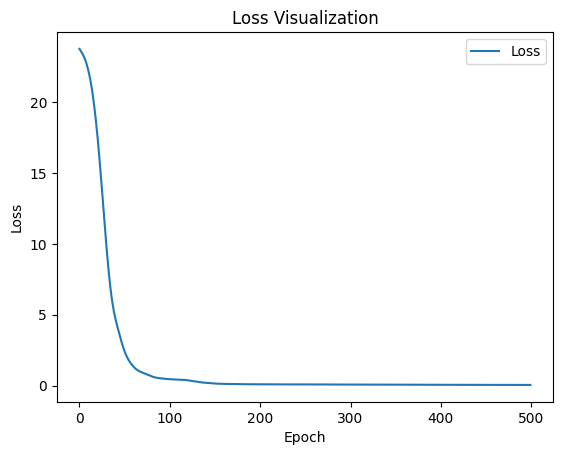

In [5]:
# show param number
print("============================================")
show_para_num(trainer.model)
visualize_loss(loss_list)

## Evaluation and plot based on mclust
SpatialFuser provides an evaluation module, *metrics*, for assessing tissue domain detection tasks. It treats the Region column in anndata.obs as the ground truth and, based on the provided embed_label (an array stored in anndata.obsm), automatically computes five metrics — ARI, AMI, Homogeneity, Completeness, and V-Measure — under clustering methods including Leiden, Louvain, and Mclust.

The original annotations of the CODEX dataset include a highly detailed set of subcell types, with a resolution far exceeding that of tissue domain annotations. For evaluation purposes, we mapped these to three parent-level cell types as highlighted in the original publication: Epithelial, Immune, and Stromal. Here, we only show these key cell types colored by Mclust using customized colors.

2025-08-25 19:55:18.860269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 19:55:19.099258: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 19:55:20.834407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/cv2/../../lib64::/usr/local/

fitting ...
  |======================================================================| 100%
             ARI       AMI Homogeneity Completeness V_Measure
mclust  0.449027  0.465004    0.454633     0.476391  0.465258


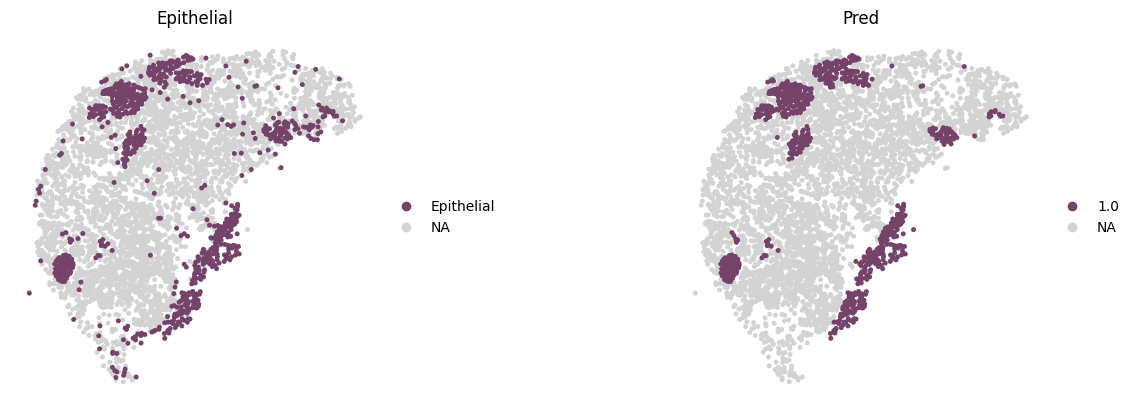

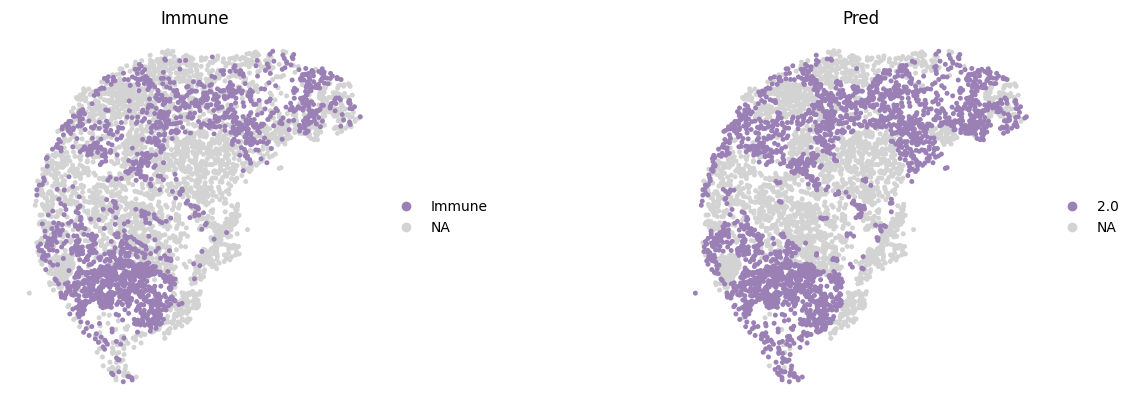

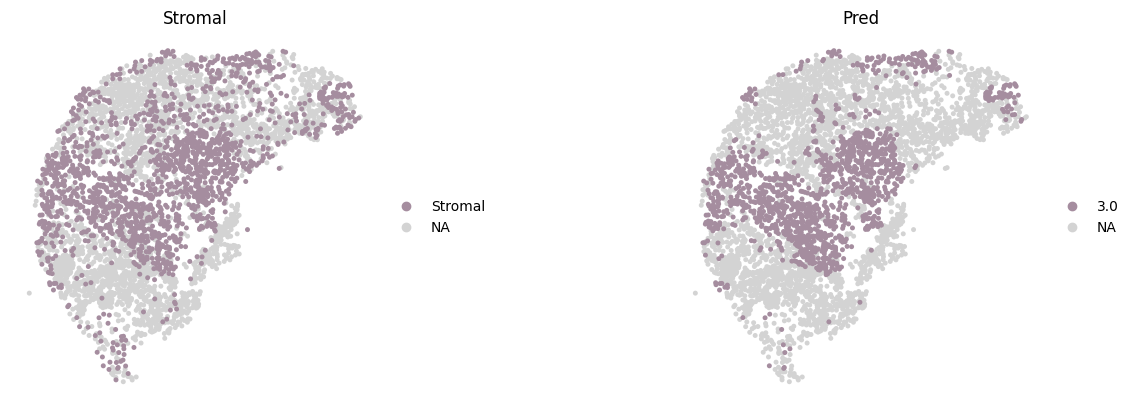

In [6]:
# evaluate and plot
leiden_result, louvain_result, mclust_result = metrics(adata,
                                                       save_loc='_codex_72_210308_mean.png',
                                                       resolution=0.1,
                                                       spot_size=0.015,
                                                       cluster_label='Region',
                                                       plot_color=["mclust"],
                                                       mclust_model='EEE',
                                                       embed_label='embedding',
                                                       vis=False,
                                                       save=False)
print(mclust_result)

adata.obs['mclust'] = adata.obs['mclust'].astype(str)

for label in ['Epithelial', 'Immune', 'Stromal']:
    adata.obs[label] = np.where(
        adata.obs['Region'] == label,
        label,
        pd.NA
    )

for clust in ['1.0', '2.0', '3.0']:
    col_name = f'mclust_{clust}'
    adata.obs[col_name] = np.where(
        adata.obs['mclust'] == clust,
        clust,
        pd.NA
    )

category_cols = ['Epithelial', 'Immune', 'Stromal', 'mclust_1.0', 'mclust_2.0', 'mclust_3.0']
adata.obs[category_cols] = adata.obs[category_cols].apply(
    lambda x: x.astype('category'),
    axis=0
)

region_color = {
    'Epithelial': "#75436A",
    'Immune': "#9A80B5",
    'Stromal': "#A58D9F",
    '1.0': "#75436A",
    '2.0': "#9A80B5",
    '3.0': "#A58D9F",
}

sc.pl.spatial(adata,
              img_key="None",
              color=['Epithelial', "mclust_1.0"],
              spot_size=0.015,
              title=['Epithelial', 'Pred'],
              wspace=0.2,
              palette=region_color,
              frameon=False,
              save='_CODEX_Epithelial.png'
              )

sc.pl.spatial(adata,
              img_key="None",
              color=['Immune', "mclust_2.0"],
              spot_size=0.015,
              title=['Immune', 'Pred'],
              wspace=0.2,
              palette=region_color,
              frameon=False,
              save='_CODEX_Immune.png'
              )

sc.pl.spatial(adata,
              img_key="None",
              color=['Stromal', "mclust_3.0"],
              spot_size=0.015,
              title=['Stromal', 'Pred'],
              wspace=0.2,
              palette=region_color,
              frameon=False,
              save='_CODEX_Stromal.png'
              )